In [1]:
import random
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import os
import pandas as pd
from PIL import Image, ImageOps

In [2]:
!pip install transformers
from transformers import BertTokenizer, TFBertModel

In [3]:
!pip install efficientnet
from efficientnet.tfkeras import EfficientNetB3

Load DistilBERT model and tokenizer

In [4]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Load EfficientNet model

In [5]:
efficientnet_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [6]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [7]:
import shutil
shutil.unpack_archive("/content/drive/MyDrive/MultiOFF_Dataset.zip", "/content/Datasets/")

In [8]:
dataset_path = '/content/Datasets/MultiOFF_Dataset/Split Dataset'

train_df = pd.read_csv(os.path.join(dataset_path, 'Training_meme_dataset.csv'))
test_df = pd.read_csv(os.path.join(dataset_path, 'Testing_meme_dataset.csv'))
val_df = pd.read_csv(os.path.join(dataset_path, 'Validation_meme_dataset.csv'))

In [9]:
image_folder = '/content/Datasets/MultiOFF_Dataset/Labelled Images'
train_df['image_name'] = train_df['image_name'].apply(lambda x: os.path.join(image_folder, x))
test_df['image_name'] = test_df['image_name'].apply(lambda x: os.path.join(image_folder, x))
val_df['image_name'] = val_df['image_name'].apply(lambda x: os.path.join(image_folder, x))

In [10]:
train_df.head()

,image_name,sentence,label
0,/content/Datasets/MultiOFF_Dataset/Labelled Im...,OFFICIAL BERNIE SANDERS DRINKING GAME ! Every ...,Non-offensiv
1,/content/Datasets/MultiOFF_Dataset/Labelled Im...,2:28 PM THIS IS A WALL INSIDE A NAZI GAS CHAMB...,offensive
2,/content/Datasets/MultiOFF_Dataset/Labelled Im...,o shit waddup ! BERNIE SANDERS COM,offensive
3,/content/Datasets/MultiOFF_Dataset/Labelled Im...,`` MITT ROMNEY IS THE WORST REPUBLICAN IN THE ...,Non-offensiv
4,/content/Datasets/MultiOFF_Dataset/Labelled Im...,Anonymous ( ID : duqdA1io a 08/05/16 ( Fri ) 1...,Non-offensiv


In [11]:
from tensorflow.keras.applications.efficientnet import preprocess_input
import cv2

def preprocess_image(image):
    target_size = (224, 224)

    # Resize the image
    if isinstance(target_size, tuple) and len(target_size) == 2 and target_size[0] > 0 and target_size[1] > 0:
        if image.shape[:2] != target_size:
            image_resized = cv2.resize(image, target_size)
        else:
            image_resized = image

    # Ensure the image has 3 channels
    if len(image_resized.shape) == 2:
        image_resized = cv2.cvtColor(image_resized, cv2.COLOR_GRAY2RGB)
    elif image_resized.shape[2] == 4:
        image_resized = image_resized[:, :, :3]  # Keep only the first 3 channels

    # Apply preprocessing specific to EfficientNet
    preprocessed_image = preprocess_input(image_resized)

    return preprocessed_image


In [12]:
def load_images_from_df(df):
    image_samples = []

    for image_name in df['image_name']:
        image = Image.open(image_name)
        image_array = np.array(image)  # Convert Image to numpy array
        preprocessed_image = preprocess_image(image_array)
        image_samples.append(preprocessed_image)

    return image_samples

In [13]:
image_train = load_images_from_df(train_df)
image_test = load_images_from_df(test_df)
image_val = load_images_from_df(val_df)

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def build_model(hp):
    # Create a Sequential model
    model = Sequential()

    # Hyperparameter: Number of convolutional layers
    num_conv_layers = hp.Int('num_conv_layers', min_value=1, max_value=4, step=1)

    # Add convolutional layers
    for i in range(num_conv_layers):
        model.add(Conv2D(
            filters=hp.Int(f'conv_{i}_filters', min_value=16, max_value=128, step=16),
            kernel_size=hp.Choice(f'conv_{i}_kernel_size', values=[3, 5]),
            activation='relu',
            padding='same'
        ))
        model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten the feature maps
    model.add(Flatten())

    # Hyperparameter: Number of dense layers
    num_dense_layers = hp.Int('num_dense_layers', min_value=1, max_value=3, step=1)

    # Add dense layers
    for i in range(num_dense_layers):
        model.add(Dense(
            units=hp.Int(f'dense_{i}_units', min_value=32, max_value=512, step=32),
            activation='relu'
        ))
        model.add(Dropout(rate=hp.Float(f'dense_{i}_dropout', min_value=0.0, max_value=0.5, step=0.1)))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification

    # Hyperparameter: Learning rate
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate),
        loss='binary_crossentropy',  # Assuming binary classification
        metrics=['accuracy']
    )
     # Define early stopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=4,
        restore_best_weights=True
    )

    # Define a model checkpoint callback
    model_checkpoint = ModelCheckpoint(
        'best_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )

    # Return the model and the callbacks
    return model, [early_stopping, model_checkpoint]

In [15]:
text_train = train_df['sentence'].tolist()
text_test = test_df['sentence'].tolist()
text_val = val_df['sentence'].tolist()
len(text_train)

445

In [16]:
labels_train = train_df['label'].values
labels_test = test_df['label'].values
labels_val = val_df['label'].values

In [17]:
label_mapping = {'Non-offensiv': 0, 'offensive': 1}
labels_train = np.array([label_mapping[label] for label in labels_train])
labels_test = np.array([label_mapping[label] for label in labels_test])
labels_val = np.array([label_mapping[label] for label in labels_val])

In [18]:
!pip install nlpaug

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 6.6 MB/s eta 0:00:00


In [19]:
# Import the necessary library
import nlpaug.augmenter.word as naw
# Define a function for text data augmentation
def augment_text_data(text_data):
    # Initialize the augmentation object
    aug = naw.SynonymAug(aug_src='wordnet')
    return aug.augment(text_data)

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [21]:
image_data_generator = ImageDataGenerator(
    rotation_range=8,      # Random rotation (degrees)
    width_shift_range=0.2,  # Random horizontal shift
    height_shift_range=0.2, # Random vertical shift
    shear_range=0.2,        # Shear intensity
    zoom_range=0.2,         # Random zoom
    horizontal_flip=True,   # Random horizontal flip
    fill_mode='nearest'     # Fill mode for filling in newly created pixels
)

In [22]:
import spacy

# Load the spaCy English model (you may need to download it first)
nlp = spacy.load("en_core_web_sm")

# Function to extract meaningful text from a sentence
def extract_meaningful_text(sentence):
    doc = nlp(sentence)
    meaningful_words = []
    for token in doc:
        # Filter out stopwords and punctuation
        if not token.is_stop and not token.is_punct:
            meaningful_words.append(token.text)
    return meaningful_words

In [23]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import random

# Load a TrueType font (.ttf) file
font_path = '/content/drive/MyDrive/arial.ttf'

# Function to overlay text on an image
def overlay_text(image, text):
    image = Image.fromarray(image)
    draw = ImageDraw.Draw(image)
    width, height = image.size

    # Set a range for font size
    min_font_size = 10
    max_font_size = 36
    font_size = random.randint(min_font_size, max_font_size)  # Random font size

    font = ImageFont.truetype(font_path, font_size)

    # Join the list elements into a single string
    text = ' '.join(text)


    # Split the text into individual words
    # words = text.split()
    words = extract_meaningful_text(text)

    for word in words:
        text_width, text_height = draw.textsize(word, font=font)
        x = random.randint(0, width - text_width)
        y = random.randint(0, height - text_height)
        draw.text((x, y), word, fill="white", font=font)

    return np.array(image)


augmented_text = []  # A list to store augmented text data
augmented_images = []  # A list to store augmented images

for i in range(len(text_train)):
    # Randomly select an image index for augmentation
    if len(text_train) > 0:
      swapped_idx = random.randint(0, len(text_train) - 1)
      # Apply image augmentation
      image_data = image_data_generator.random_transform(image_train[swapped_idx])
      # Overlay text on the augmented image
      image_with_text = overlay_text(image_data, text_train[i])

      # Apply text augmentation
      text_train[i] = augment_text_data(text_train[i])

      # Tokenize and limit sequence length for text data
      tokens = bert_tokenizer(text_train[i], truncation=True, padding='max_length', max_length=128)
      # Append the augmented text and image data
      augmented_text.append(' '.join(tokens))

      # Preprocess the image
      preprocessed_image = preprocess_image(image_with_text)

      augmented_images.append(preprocessed_image)


Streaming output truncated to the last 5000 lines.
<ipython-input-23-160bf0ea108c>:30: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(word, font=font)
<ipython-input-23-160bf0ea108c>:30: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(word, font=font)
<ipython-input-23-160bf0ea108c>:30: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(word, font=font)
<ipython-input-23-160bf0ea108c>:30: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(word, font=font)
<ipython-input-23-160bf0ea108c>:30: DeprecationWarning: textsize 

In [24]:
# Tokenize and encode the augmented text data using the XLNet tokenizer
text_encodings = bert_tokenizer(augmented_text, padding=True, truncation=True, return_tensors='tf')

# Get the input IDs for the text data
input_ids = text_encodings['input_ids']
attention_mask = text_encodings['attention_mask']

# Generate embeddings for text data
text_embeddings = bert_model(input_ids, attention_mask=attention_mask)["last_hidden_state"]

In [25]:
batch_size = 64  # Adjust this for RAM usage
num_samples = len(augmented_text)
num_batches = (num_samples + batch_size - 1) // batch_size

In [26]:
# Convert image data to TensorFlow tensor
# Ensure all images have the same dimensions
# augmented_image = [img for img in augmented_image if img.shape == (224, 224, 3)]

# Convert the list of images to a 4D NumPy array
image_data = np.stack(augmented_images)

# Convert the NumPy array to a TensorFlow tensor
image_data = tf.convert_to_tensor(image_data, dtype=tf.float32)
# image_data = tf.convert_to_tensor(image_data, dtype=tf.float32)

In [27]:
image_data.shape

TensorShape([445, 224, 224, 3])

In [28]:
# Process image data through EfficientNet
image_embeddings = efficientnet_model.predict(image_data)

14/14 [==============================] - 8s 64ms/step


In [29]:
image_embeddings.shape

(445, 7, 7, 1536)

In [30]:
from tensorflow.keras.layers import Dense

# Add a Dense layer to reduce the dimensionality of text embeddings
text_embeddings = Dense(62720, activation='relu')(text_embeddings)

In [31]:

# Flatten the image embeddings
flattened_image_embeddings = tf.keras.layers.Flatten()(image_embeddings)
# Flatten the text embeddings
flattened_text_embeddings = tf.keras.layers.Flatten()(text_embeddings)

# Concatenate the flattened text embeddings with the flattened image embeddings
combined_embeddings = tf.concat([flattened_text_embeddings, flattened_image_embeddings], axis=1)

In [32]:
image_embeddings.shape

(445, 7, 7, 1536)

In [33]:
text_embeddings.shape

TensorShape([445, 15, 62720])

In [34]:
combined_embeddings.shape

TensorShape([445, 1016064])

In [35]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Concatenate

# Define a more complex text branch
text_input = Input(shape=(10, 62720), name='text_input')
text_flatten = Flatten()(text_input)
text_dense = Dense(256, activation='relu')(text_flatten)
text_dropout = Dropout(0.5)(text_dense)

# Define a more complex image branch
image_input = Input(shape=(7, 7, 1536), name='image_input')
image_flatten = Flatten()(image_input)
image_dense = Dense(256, activation='relu')(image_flatten)
image_dropout = Dropout(0.5)(image_dense)

# Combine the branches
combined = Concatenate()([text_dropout, image_dropout])
combined_dense = Dense(128, activation='relu')(combined)
output = Dense(1, activation='sigmoid')(combined_dense)

# Create the model
combined_model = Model(inputs=[text_input, image_input], outputs=output)
optimizer = Adam(learning_rate=0.01)
combined_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Print the summary of the model
combined_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None, 10, 62720)]          0         []                            
                                                                                                  
 image_input (InputLayer)    [(None, 7, 7, 1536)]         0         []                            
                                                                                                  
 flatten_2 (Flatten)         (None, 627200)               0         ['text_input[0][0]']          
                                                                                                  
 flatten_3 (Flatten)         (None, 75264)                0         ['image_input[0][0]']         
                                                                                              

In [36]:
# ... (previous parts of your code)

# Flatten the image embeddings
flattened_image_embeddings = tf.keras.layers.Flatten()(image_embeddings)
# Flatten the text embeddings
flattened_text_embeddings = tf.keras.layers.Flatten()(text_embeddings)

# Concatenate the flattened text embeddings with the flattened image embeddings
combined_embeddings = tf.concat([flattened_text_embeddings, flattened_image_embeddings], axis=1)

In [37]:
image_embeddings.shape

(445, 7, 7, 1536)

In [38]:
text_embeddings.shape

TensorShape([445, 15, 62720])

In [39]:
combined_embeddings.shape

TensorShape([445, 1016064])

In [40]:
import tensorflow as tf
# Splitting the data using indices
indices = np.arange(len(text_embeddings))
indices_train, indices_val, _, _ = train_test_split(
    indices, labels_train, test_size=0.2, random_state=42
)
# Convert NumPy arrays to TensorFlow tensors
indices_train_tf = tf.convert_to_tensor(indices_train)
indices_val_tf = tf.convert_to_tensor(indices_val)

X_train_text = tf.gather(text_embeddings, indices_train_tf)
X_val_text = tf.gather(text_embeddings, indices_val_tf)
X_train_img = tf.gather(image_embeddings, indices_train_tf)
X_val_img = tf.gather(image_embeddings, indices_val_tf)
y_train = tf.gather(labels_train, indices_train_tf)
y_val = tf.gather(labels_train, indices_val_tf)

In [41]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Pad the text data to have a sequence length of 10
X_train_text_padded = pad_sequences(X_train_text, maxlen=10, padding='post', truncating='post', dtype='float32')
X_val_text_padded = pad_sequences(X_val_text, maxlen=10, padding='post', truncating='post', dtype='float32')

In [42]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=4,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the model weights from the epoch with the best validation loss
)

# Define a model checkpoint callback to save the best model during training
model_checkpoint = ModelCheckpoint(
    'best_model.h5',        # Filepath to save the best model
    monitor='val_loss',     # Monitor validation loss
    save_best_only=True,    # Save only the best model
    verbose=1                # Verbosity mode, 1 for progress bar
)

In [43]:
np.unique(labels_train)

array([0, 1])

In [44]:
import numpy as np

# Assuming labels_train contains your training labels
unique_classes, class_counts = np.unique(labels_train, return_counts=True)
total_samples = len(labels_train)

# Calculate class weights as inversely proportional to class frequencies
class_weights = {cls: total_samples / (len(unique_classes) * count) for cls, count in zip(unique_classes, class_counts)}

In [45]:
from tensorflow.keras.callbacks import LearningRateScheduler

# Define a learning rate schedule function
def step_decay(epoch):
    initial_lr = 0.01  # Initial learning rate
    drop = 0.5         # Factor by which the learning rate will be reduced
    epochs_drop = 10   # Number of epochs after which learning rate will drop
    lr = initial_lr * (drop ** (epoch // epochs_drop))
    return lr

# Create an instance of LearningRateScheduler
lr_scheduler = LearningRateScheduler(step_decay)

In [46]:
history = combined_model.fit(
        [X_train_text_padded, X_train_img],
        y_train,
        batch_size=batch_size,
        epochs=32,
        validation_data=([X_val_text_padded, X_val_img], y_val),
        class_weight=class_weights,
        callbacks=[lr_scheduler, early_stopping, model_checkpoint]
    )


Epoch 1/32
5/6 [========================>.....] - ETA: 0s - loss: 601495.1250 - accuracy: 0.5875
Epoch 1: val_loss improved from inf to 388489.15625, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 11s 2s/step - loss: 596814.5000 - accuracy: 0.5674 - val_loss: 388489.1562 - val_accuracy: 0.5843 - lr: 0.0100
Epoch 2/32
5/6 [========================>.....] - ETA: 0s - loss: 143421.6562 - accuracy: 0.5594
Epoch 2: val_loss improved from 388489.15625 to 59126.73438, saving model to best_model.h5
6/6 [==============================] - 7s 1s/step - loss: 136708.6250 - accuracy: 0.5365 - val_loss: 59126.7344 - val_accuracy: 0.5843 - lr: 0.0100
Epoch 3/32
5/6 [========================>.....] - ETA: 0s - loss: 41823.8203 - accuracy: 0.5906
Epoch 3: val_loss improved from 59126.73438 to 33250.07422, saving model to best_model.h5
6/6 [==============================] - 10s 2s/step - loss: 38921.3516 - accuracy: 0.5927 - val_loss: 33250.0742 - val_accuracy: 0.5618 - lr: 0.0100
Epoch 4/32
5/6 [========================>.....] - ETA: 0s - loss: 42338.0703 - accuracy: 0.5125
Epoch 4: val_loss improved from 33250.07422 to 31024.39648, saving model to best_mod

In [47]:
# Tokenize and encode the test texts
test_encodings = bert_tokenizer(text_test, truncation=True, padding=True, return_tensors='tf')

# Get the input IDs for the test data
input_ids_test = test_encodings['input_ids']
image_test = np.array(image_test)
print("Image type:", type(image_test))
print("Image shape:", image_test.shape)
preprocessed_images = []

for image_data in image_test:
    preprocessed_image = preprocess_image(image_data)
    preprocessed_images.append(preprocessed_image)

# Convert the list of preprocessed images to a NumPy array
preprocessed_images = np.array(preprocessed_images)
# Ensure that X_test_text has the same shape as expected by the model (sequence length of 10 and embedding size of 62720)
# You can pad or truncate as needed
if input_ids_test.shape[1] < 10:
    padding_size = 10 - input_ids_test.shape[1]
    input_ids_test = np.pad(input_ids_test, ((0, 0), (0, padding_size)), mode='constant')
elif input_ids_test.shape[1] > 10:
    input_ids_test = input_ids_test[:, :10]
# Now, you can use preprocessed_images for prediction with your EfficientNet model
X_test_img = efficientnet_model.predict(preprocessed_images)
X_test_text = bert_model.predict(input_ids_test)[0]  # Assuming the model returns a tuple and we want the first element
print("X_test_text shape:", X_test_text.shape)
print("X_test_img shape:", X_test_img.shape)

Image type: <class 'numpy.ndarray'>
Image shape: (149, 224, 224, 3)
5/5 [==============================] - 6s 25ms/step
X_test_text shape: (149, 10, 768)
X_test_img shape: (149, 7, 7, 1536)


In [48]:
import numpy as np

# Assuming X_test_text has shape (None, 10, 768)
desired_shape = (X_test_text.shape[0], 10, 62720)

# Pad with zeros if the shape is smaller, or truncate if larger
if X_test_text.shape[2] < desired_shape[2]:
    padding = np.zeros((desired_shape[0], 10, desired_shape[2] - X_test_text.shape[2]))
    X_test_text_padded = np.concatenate((X_test_text, padding), axis=2)
elif X_test_text.shape[2] > desired_shape[2]:
    X_test_text_padded = X_test_text[:, :, :desired_shape[2]]
else:
    X_test_text_padded = X_test_text  # No need to pad or truncate

X_test_text_padded.shape

(149, 10, 62720)

In [49]:
from tensorflow.keras.models import load_model

# Load the best model
best_model = load_model('best_model.h5')

In [50]:
test_predictions = best_model.predict([X_test_text_padded, X_test_img])

5/5 [==============================] - 0s 24ms/step


In [51]:
threshold = 0.5
binary_predictions = (test_predictions > threshold).astype(int)

In [52]:
from sklearn.metrics import accuracy_score

# Assuming labels_test contains the true labels for your test data
accuracy = accuracy_score(labels_test, binary_predictions)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.48322147651006714


In [53]:
from sklearn.metrics import precision_score, recall_score

precision = precision_score(labels_test, binary_predictions)
recall = recall_score(labels_test, binary_predictions)

print("Precision:", precision)
print("Recall:", recall)

Precision: 0.411214953271028
Recall: 0.7586206896551724


In [54]:
from sklearn.metrics import f1_score

f1 = f1_score(labels_test, binary_predictions)
print("F1-Score:", f1)

F1-Score: 0.5333333333333333


In [55]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(labels_test, binary_predictions)
print("Confusion Matrix:\n", cm)


Confusion Matrix:
 [[28 63]
 [14 44]]


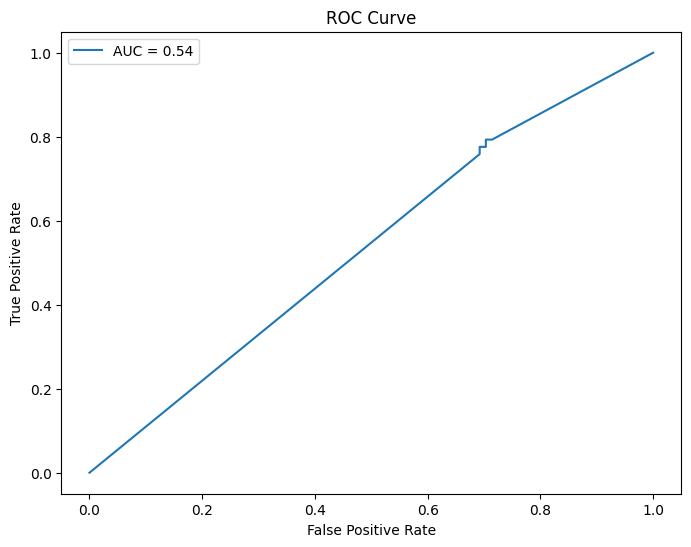

AUC: 0.5359984842743464


In [56]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(labels_test, test_predictions)
auc = roc_auc_score(labels_test, test_predictions)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

print("AUC:", auc)
